

<img src="https://neokyo.com/blog/wp-content/uploads/2019/02/ogp_new.png">

Mercari, Japan's biggest community-powered shopping app provides a marketplace for seller to sell a wide variety of products. Mercari would like to offer a pricing suggesition to its sellers. This is a tough task considering the huge amout of products solds online. Also items such as clothings have seasonal pricing trends and are higly influenced by brand names, while prices of electronics are influenced by spec of the product among other factors.

The task is to build an algorithm that automatically suggests the right product prices based product details such as item description, item category, brand name and item condition.

### Dataset

The data consist of a list of product listings. These files are tab-delimited.
- train_id or test_id - the id of the listing
- name - the title of the listing. 
- item_condition_id - the condition of the items provided by the seller
- category_name - category of the listing
- brand_name
- price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. 
- shipping - 1 if shipping fee is paid by seller and 0 if paid by the buyer
- item_description - the full description of the item. 

**Source:** https://www.kaggle.com/c/mercari-price-suggestion-challenge

-------------------------------------------------------------------------------------------------------------------

In [1]:
#importing packages, modules and dependencies
import sys
sys.path.append('./modules') # appending created module folder to the search path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import NLP_project_helper as hlp   #created module that contains several customized functions built for this project 
import sklearn
import joblib

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack

from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import eli5

from functools import partial
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_union
import importlib
from unidecode import unidecode #tries to get equivalent of unicode characters in ASCII
import copy


from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
#Settings
pd.options.mode.use_inf_as_na = True #counting empty strings as NaN

In [112]:
#importing train dataset
train = pd.read_csv("train.tsv", sep= '\t', header = 0) #loading the training data set

In [914]:
train.head(20)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


## Summary Stats

In [113]:
hlp.summary_stat(train) 

Data has 1482535 rows by 8 columns

Data type
train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
count,1.482535e+06,1482535,1.482535e+06,1476208,849853,1.482535e+06,1.482535e+06,1482531
unique,NaN,1225273,NaN,1287,4809,NaN,NaN,1281426
top,NaN,Bundle,NaN,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,NaN,NaN,No description yet
freq,NaN,2232,NaN,60177,54088,NaN,NaN,82489
mean,7.412670e+05,NaN,1.907380e+00,NaN,NaN,2.673752e+01,4.472744e-01,NaN
std,4.279711e+05,NaN,9.031586e-01,NaN,NaN,3.858607e+01,4.972124e-01,NaN
min,0.000000e+00,NaN,1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,NaN
25%,3.706335e+05,NaN,1.000000e+00,NaN,NaN,1.000000e+01,0.000000e+00,NaN
50%,7.412670e+05,NaN,2.000000e+00,NaN,NaN,1.700000e+01,0.000000e+00,NaN
75%,1.111900e+06,NaN,3.000000e+00,NaN,NaN,2.900000e+01,1.000000e+00,NaN


### Observations from Summary Stats

- Data types are as expected. Features that should be strings, are, and features that should be numbers are.

- There are prices that are zero dollars. This is probably an error as there is no information about free stuffs on Mercarri.

- Also looking at the percentile we see that 75% of the price values are 29 dollars or less but the maximum price value is 2009 dollars which suggests that the price distribution is not symmetrical and it has a long tail.

- Half of Item_condition values are between 1 and 2, and the other half are from 2 to 5

- For item_description, 'No description yet' is the most common description but it does not mean a lot. Also we see that the sum of occurences of 'No description yet' and the unique values does not equal to the count of values in item_description. This means that there is at least one other description value that occurs multiple times or it could just be NaN.

We'll explore all of these further.

-----------------------------------------------------------------------------------------------------------------------

 There are 874 rows with zero price values which is not a lot in a dataset of over 1 million rows. So we'll remove them from our data set

In [114]:
train = hlp.drop_zero(train, 'price') #returns data minus rows with 0 price values


 Dropped 874 rows with zero price values


In [7]:
train[train['price']==train['price'].min()]   #min price after dropping zero values is 3 which is more reasonable

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
88,88,Misty tentacruel foil pokemon card,3,Vintage & Collectibles/Trading Cards/Animation,Pokemon,3.0,1,I have 2 available
203,203,Racerback tank top,3,"Women/Tops & Blouses/Tank, Cami",NaN,3.0,1,Tiny hole at the back barely noticeable
240,240,1998 SP Authentic Derek Jeter,2,Vintage & Collectibles/Trading Cards/Sports,MLB,3.0,1,1998 SP Authentic Derek Jeter #145
390,390,nails and nail polish set,1,Beauty/Makeup/Nails,NaN,3.0,1,Comes with both.
444,444,35 thank you stickers free shipping,1,Other/Office supplies/Shipping Supplies,NaN,3.0,1,Free shipping You'll receive 7 strips of 5 sti...
...,...,...,...,...,...,...,...,...
1482342,1482342,(6) Hawaiian Polymailers,1,Other/Office supplies/Shipping Supplies,NaN,3.0,1,"✨ Brand new, Never used ✨ The listing is still..."
1482369,1482369,2 biore pore strips,1,Beauty/Skin Care/Face,NaN,3.0,1,"2 for 3$, will ship via stamp"
1482398,1482398,Shuckle,2,Vintage & Collectibles/Trading Cards/Vintage,Pokemon,3.0,1,Near mint holo card
1482420,1482420,AE white tank,2,"Women/Tops & Blouses/Tank, Cami",American Eagle,3.0,1,NWOT size medium white tank top. Super soft an...


-----------------------------------------------------------------------------------------------------------------------
Checking for number of unique values in each feature as the summary stat above does not provide unique values for integers. There are 5 levels of item conditions as expected and 2 options for shipping

In [26]:
hlp.uniq_values_in_feature(train, list(train.columns))


There are 1481661  unique values of train_id
There are 1224596  unique values of name
There are 5  unique values of item_condition_id
There are 1288  unique values of category_name
There are 4808  unique values of brand_name
There are 827  unique values of price
There are 2  unique values of shipping
There are 1280672  unique values of item_description


-----------------------------------------------------------------------------------------------------------------------
Checking for missing values including empty strings and NaN

In [119]:
hlp.missing_count(train)

Missing Data
train_id   ---->  0 ( 0.0 % )
name   ---->  0 ( 0.0 % )
item_condition_id   ---->  0 ( 0.0 % )
category_name   ---->  6314 ( 0.4 % )
brand_name   ---->  632336 ( 42.7 % )
price   ---->  0 ( 0.0 % )
shipping   ---->  0 ( 0.0 % )
item_description   ---->  4 ( 0.0 % )


- Almost half of the items do not have a brand name and less than 1% do not have a category_name. 
- It was noted earlier that there is at least one  other values in _item_description_ that occur multiple times which could be empty strings or NAN. From the above we know that there are very few empty strings and/or NAN.


-----------------------------------------------------------------------------------------------------------------------
### Exploring multiple occurring _item_description_ values

In [917]:
item_description_cnts = pd.DataFrame(train['item_description'].value_counts(dropna = False))
item_description_cnts.rename(columns={'item_description': 'occurence'}, inplace = True)
item_description_cnts[item_description_cnts['occurence']>20]

,occurence
No description yet,82489
New,4099
Brand new,3058
Good condition,1274
Great condition,1158
...,...
"100% Organic African Black Soap from Ghana I sell top quality African Black Soap Imported from Ghana! Don't believe me?? Compare Prices!! Helps to remove scars caused by acne.Since acne is not caused by dirt, but due to the release of excessive oils within the skin, the soap cannot remove acne. But use of African black soap helps to remove scars cause due to acne. Helps to remove skin irritations. Use of black soap helps to remove skin irritations like rashes. Suitable for all skin types. Black soap can be used for the treatment of problems on all types of skin including the dry and rough, oily and moderate skins. Beneficial for skin diseases. Black soap is very beneficial for reducing the discomforts that are associated with skin diseases like psoriasis and eczema Delays ageing on the skin. Regular use of black soap helps to remove facial lines that are mostly early signs of ageing. This black soap can be used to delay ageing of skin.",21
Brand new. Still in package.,21
Brand New Case with free shipping,21
Only worn a couple times,21


----------------------------------------------------------------------------------------------------------------------
There are 613 unique _item_description_ values that occur multiple times ranging from single word to sentences
For the long item descriptions as in the example below, we would expect the items to be very similar.
If those items are very different but described in the same way, then item_description might not be such a good predictor. Those items with the exact same long description are most likely similar itmes from the same seller 

In the example below with the item_description __"⚠️PLEASE READ⚠️ ‼️Orders will be shipped next day ‼️Delivery takes 3 to 5 business days ‼️Price is Firm •100% UV Protection (UVA and UVB) •Clear Lens Glasses •For fashion use •NON-RX (non-prescription) •Great for daily use!"__, the description is quite generic but there are some unique words like lens, glasses, that might help our model learn. 
We also see a correlation with category_names as those items are all catogerised under "Women/Women's Accessories/Sunglasse" and have no brand name

In [63]:
train[train['item_description'] == '⚠️PLEASE READ⚠️ ‼️Orders will be shipped next day ‼️Delivery takes 3 to 5 business days ‼️Price is Firm •100% UV Protection (UVA and UVB) •Clear Lens Glasses •For fashion use •NON-RX (non-prescription) •Great for daily use!' ]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
41136,41136,Clear Retro Wayfarer Glasses,1,Women/Women's Accessories/Sunglasses,NaN,7.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
43207,43207,Black Gold Clear Diamond Cut Glasses,1,Women/Women's Accessories/Sunglasses,NaN,7.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
50348,50348,Black Silver Clear Round Retro Glasses,1,Women/Women's Accessories/Sunglasses,NaN,8.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
56304,56304,Black Gold clear Round Nerd Glasses,1,Women/Women's Accessories/Sunglasses,NaN,8.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
62682,62682,Purple Mirrored Aviator Sunglasses,1,Women/Women's Accessories/Sunglasses,NaN,10.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
...,...,...,...,...,...,...,...,...
1446344,1446344,Tortoise gold Clear Clubmaste glasses,1,Women/Women's Accessories/Sunglasses,NaN,6.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
1457586,1457586,Black Gold Clear Clubmaster Glasses,1,Women/Women's Accessories/Sunglasses,NaN,9.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
1469347,1469347,Gold Octagon&Gold Aviator Clear Glasses,1,Women/Women's Accessories/Sunglasses,NaN,14.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
1473773,1473773,Clear Frame Aviator Glasses,1,Women/Women's Accessories/Sunglasses,NaN,9.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...


-----------------------------------------------------------------------------------------------------------------------
For the _item_description_ __"New"__ we expect the _item_condition_id_ to be mostly 1 which is what is seen below

In [90]:
train[(train['item_description'] == 'New') & (train['item_condition_id']<5) & (train['item_condition_id']>0) ]['item_condition_id'].value_counts()

1    3752
2     333
3      14
Name: item_condition_id, dtype: int64

-----------------------------------------------------------------------------------------------------------------------
### Exploring items without a category name and also Items without a brandname

As shown below, from the name columns for some of the items without a category name, it is possible to infer a category for them. For example there is an item named "ACER Laptop" and another named "3 Nora Roberts books".

Similary, items without a brand name provide some hints in the names of the items. An example is the item with the name ACER Laptop which also is not given a brandname. Another example is an item with the name Dyson hot+cool which is not given a brandname but it is clearly a Dyson brand. Also we see the items without a given brandname but the brand is mentioined in the item description.


In [921]:
train_no_cat = train[train['category_name'].isna()]
train_no_cat

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
122,122,Bundle,3,NaN,NaN,59.0,0,Sizes and info of clothes can be found on thei...
155,155,3 Nora Roberts Books,3,NaN,NaN,10.0,1,For aferg16.
258,258,ACER Laptop,5,NaN,NaN,14.0,0,"Powers on, no screen display, no external dama..."
984,984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,NaN,Michael Kors,18.0,0,No description yet
1185,1185,Teenage Mutant Ninja Turtle Van/ Extras,3,NaN,Nickelodeon,9.0,0,"Teenage Mutant Ninja Turtle Van, April O'Neil ..."
...,...,...,...,...,...,...,...,...
1481249,1481249,Only For Erin. Do Not Buy,3,NaN,NaN,31.0,0,No description yet
1481750,1481750,American Eagle Jeggings,2,NaN,American Eagle,17.0,0,Worn a couple of time Size 4
1482252,1482252,Bundle For All Honey :),3,NaN,NaN,40.0,0,No description yet
1482443,1482443,HOLD 14g Purple Prong Nipple Bars Rings,1,NaN,NaN,22.0,1,14g Purple Prong Set Nipple Bars Rings [surgic...


In [920]:
train_no_brandname = train[train['brand_name'].isna()]
train_no_brandname

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...
...,...,...,...,...,...,...,...,...
1482526,1482526,Harry Potter Shirt! Women M/ Girl XL,2,Women/Tops & Blouses/T-Shirts,NaN,12.0,0,"Great Harry Potter Shirt! ""Hogwarts, School of..."
1482527,1482527,Blk/white ribbed mock neck bodysuit M,1,Women/Tops & Blouses/Blouse,NaN,10.0,1,Brand new black and white ribbed mock neck bod...
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


-----------------------------------------------------------------------------------------------------------------------
#### Replacing Empty Strings and NaN
Some machine learning algorithms such as Linear regression can not process NaN. The code below is to replace any NaN and missing values and then recheck


In [120]:
values = {'category_name': 'unknown', 'brand_name': 'not provided', 'item_description': 'No description yet'}
train.fillna(value = values, inplace = True)
hlp.missing_count(train)

Missing Data
train_id   ---->  0 ( 0.0 % )
name   ---->  0 ( 0.0 % )
item_condition_id   ---->  0 ( 0.0 % )
category_name   ---->  0 ( 0.0 % )
brand_name   ---->  0 ( 0.0 % )
price   ---->  0 ( 0.0 % )
shipping   ---->  0 ( 0.0 % )
item_description   ---->  0 ( 0.0 % )


In [121]:
joblib.dump(train, 'train_checkpoint1')

['train_checkpoint1']

-----------------------------------------------------------------------------------------------------------------------
#### Converting/Removing Non-ASCII characters and making all characters uniform 
There are some Non-ASCII characters such as 'ʜᴀᴠᴇ', 'ғʀᴇᴇ', 'ᴀɴʏ', 'ᴘʟᴇᴀsᴇ', 'ᴛᴏ', and symbols in the data. Although some can be pronounced in English, we would not want to have for example 'HAVE' and 'ʜᴀᴠᴇ' as two separte tokens. 

Using the Unidecode library we are going to attempt to convert the unicode characters not in ASCII into ASCII characters. It does this cleverly through transliteration and the ones that cannot be ASCII encoded are ignored. For example:

unidecode('ʜᴀᴠᴇ')
>'HAVE'


In [134]:
#First line converts all object type columns into ascii characters and second line checks if it is done properly
train = conv_to_ascii(train)
hlp.check_non_ascii(x)  #returns no error which means conversion was successful

In [136]:
joblib.dump(train, "train_non_ascii")

['train_non_ascii']

For uniformity and to aid processing all characters are converted to lowercase

In [137]:
#first line converts all object type columns to lowercase and second line verifies that they are all in lower case
train = hlp.case_selection(train, case = 'lower') 
hlp.case_check(train)

Checking if case in feature values are uniform
name ---> All lowercase
category_name ---> All lowercase
brand_name ---> All lowercase
item_description ---> All lowercase



,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,mlb cincinnati reds t shirt size xl,3,men/tops/t-shirts,not provided,10.0,1,no description yet
1,1,razer blackwidow chroma keyboard,3,electronics/computers & tablets/components & p...,razer,52.0,0,this keyboard is in great condition and works ...
2,2,ava-viv blouse,1,women/tops & blouses/blouse,target,10.0,1,adorable top with a hint of lace and a key hol...
3,3,leather horse statues,1,home/home decor/home decor accents,not provided,35.0,1,new with tags. leather horses. retail for [rm]...
4,4,24k gold plated rose,1,women/jewelry/necklaces,not provided,44.0,0,complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
1482530,1482530,free people inspired dress,2,women/dresses/mid-calf,free people,20.0,1,"lace, says size small but fits medium perfectl..."
1482531,1482531,little mermaid handmade dress,2,kids/girls 2t-5t/dresses,disney,14.0,0,little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,sports & outdoors/exercise/fitness accessories,not provided,12.0,0,"used once or twice, still in great shape."
1482533,1482533,world markets lanterns,3,home/home decor/home decor accents,not provided,45.0,1,there is 2 of each one that you see! so 2 red ...


In [138]:
joblib.dump(train, "train_lowercase")

['train_lowercase']

## EDA & Visualizations

Earlier, it was mentioned that 75% of the price values are less than $25 and so the distribution is expected to have a long tail. We see this in the graph below on the left. The price distribution is heavily skewed to the left and so the dataset might not work particularly well with linear regression models. Hence we apply a log transformation to make the distribution as normal as possible. More so, the required scoring method for the model is root mean squared log error (RMSLE).

The log transformed data is shown on the right

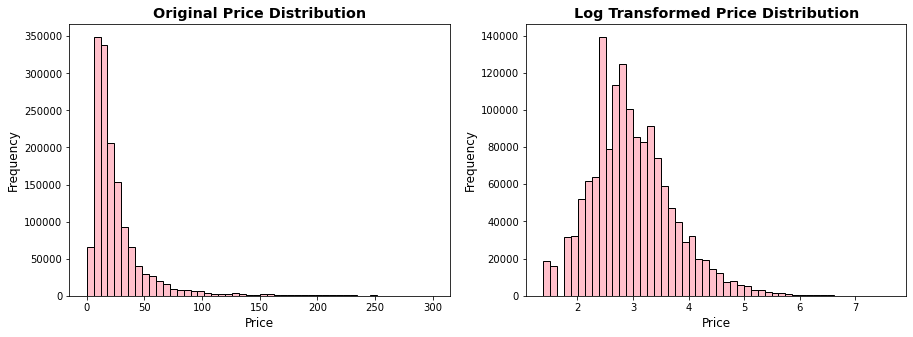

In [139]:
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(train['price'], bins = 50, range = [0, 300], linewidth=1, edgecolor="black", facecolor = 'pink')
ax[0].set_xlabel('Price', fontsize = 'large')
ax[0].set_ylabel('Frequency', fontsize = 'large')
ax[0].set_title('Original Price Distribution', fontsize = 'x-large', fontweight = 'bold')

ax[1].hist(np.log1p(train['price']), bins = 50,  linewidth=1, edgecolor="black", facecolor = 'pink')
ax[1].set_xlabel('Price', fontsize = 'large')
ax[1].set_ylabel('Frequency', fontsize = 'large')
ax[1].set_title('Log Transformed Price Distribution', fontsize = 'x-large', fontweight = 'bold')

plt.show()

In [141]:
train['log_price'] = np.log1p(train['price']) #creating a new column for log transformed price

In [142]:
joblib.dump(train, 'train_logprice')

['train_logprice']

-----------------------------------------------------------------------------------------------------------------------
The top ten categories for the listed items are shown below. We see that eight of the top ten are feminine product if   beauty items are categorized as feminine

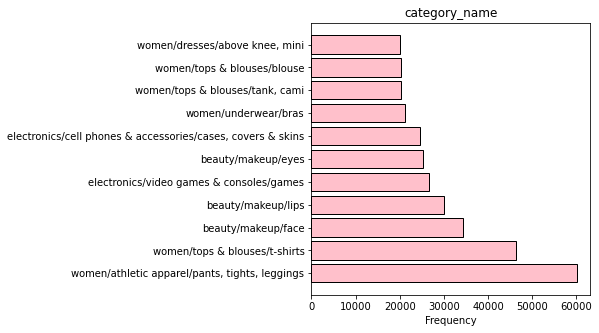

In [209]:
hlp.cat_chart(train, 'category_name')

----------------------------------------------------------------------------------------------------------------------
Below, the _category_name_ is broken into 5 subcategories with the majority of the data falling into the first three categories

In [144]:
subcat = (train['category_name']).str.split("/", n = 0, expand = True)
subcat

,0,1,2,3,4
0,men,tops,t-shirts,None,None
1,electronics,computers & tablets,components & parts,None,None
2,women,tops & blouses,blouse,None,None
3,home,home decor,home decor accents,None,None
4,women,jewelry,necklaces,None,None
...,...,...,...,...,...
1482530,women,dresses,mid-calf,None,None
1482531,kids,girls 2t-5t,dresses,None,None
1482532,sports & outdoors,exercise,fitness accessories,None,None
1482533,home,home decor,home decor accents,None,None


In [145]:
#appending the subcategories into the training data
subcategory = ['maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
for i in range (0,5):
    train[subcategory[i]] = subcat[i]

In [146]:
train

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,maincat,subcat1,subcat2,subcat3,subcat4
0,0,mlb cincinnati reds t shirt size xl,3,men/tops/t-shirts,not provided,10.0,1,no description yet,2.397895,men,tops,t-shirts,None,None
1,1,razer blackwidow chroma keyboard,3,electronics/computers & tablets/components & p...,razer,52.0,0,this keyboard is in great condition and works ...,3.970292,electronics,computers & tablets,components & parts,None,None
2,2,ava-viv blouse,1,women/tops & blouses/blouse,target,10.0,1,adorable top with a hint of lace and a key hol...,2.397895,women,tops & blouses,blouse,None,None
3,3,leather horse statues,1,home/home decor/home decor accents,not provided,35.0,1,new with tags. leather horses. retail for [rm]...,3.583519,home,home decor,home decor accents,None,None
4,4,24k gold plated rose,1,women/jewelry/necklaces,not provided,44.0,0,complete with certificate of authenticity,3.806662,women,jewelry,necklaces,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,free people inspired dress,2,women/dresses/mid-calf,free people,20.0,1,"lace, says size small but fits medium perfectl...",3.044522,women,dresses,mid-calf,None,None
1482531,1482531,little mermaid handmade dress,2,kids/girls 2t-5t/dresses,disney,14.0,0,little mermaid handmade dress never worn size 2t,2.708050,kids,girls 2t-5t,dresses,None,None
1482532,1482532,21 day fix containers and eating plan,2,sports & outdoors/exercise/fitness accessories,not provided,12.0,0,"used once or twice, still in great shape.",2.564949,sports & outdoors,exercise,fitness accessories,None,None
1482533,1482533,world markets lanterns,3,home/home decor/home decor accents,not provided,45.0,1,there is 2 of each one that you see! so 2 red ...,3.828641,home,home decor,home decor accents,None,None


In [147]:
#replacing all the None values in the subcategories with 'unknown'
values = {'subcat1': 'unknown', 'subcat2': 'unknown', 'subcat3': 'unknown', 'subcat4': 'unknown'}
train.fillna(value = values, inplace = True)

In [148]:
joblib.dump(train, 'train_subcat')

['train_subcat']

-----------------------------------------------------------------------------------------------------------------------
Chart below show that Women and beauty product make up more than half of the listed items

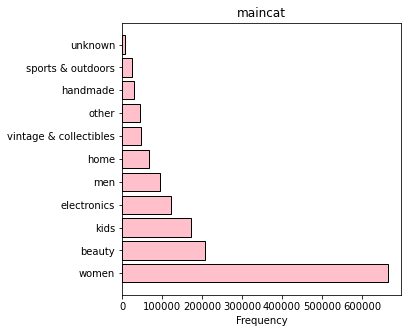

In [208]:
hlp.cat_chart(train, 'maincat')

----------------------------------------------------------------------------------------------------------------------
Most items are rated from excellent/new to average conditions (1-3) 

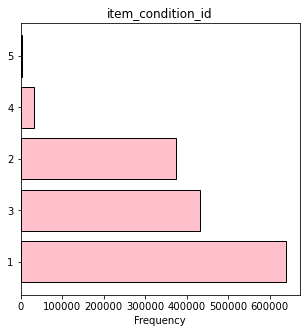

In [211]:
hlp.cat_chart(train, 'item_condition_id')

-----------------------------------------------------------------------------------------------------------------------
Grouping the data by the main categories, we see that not only one or a few categories contribute to the skewness of the price dristribution, but rather all. The largest range from the min to the 75th percentile price in any category is $37 ( men's category), but the max price in each category is tens to a hundred of magnitude of this value

In [149]:
#Price distribution of main categories
maincat_group = train.groupby('maincat').describe()
maincat_group['price']

,count,mean,std,min,25%,50%,75%,max
maincat,,,,,,,,
beauty,207725.0,19.681290,21.360937,3.0,10.0,15.0,24.0,2000.0
electronics,122632.0,35.190558,65.430780,3.0,9.0,15.0,31.0,1909.0
handmade,30835.0,18.160694,27.760091,3.0,6.0,12.0,20.0,1750.0
home,67831.0,24.551068,24.416986,3.0,12.0,18.0,29.0,848.0
kids,171555.0,20.658439,22.732427,3.0,10.0,14.0,24.0,809.0
men,93609.0,34.734940,41.244610,3.0,14.0,21.0,40.0,1309.0
other,45329.0,20.819917,29.851479,3.0,9.0,14.0,23.0,1400.0
sports & outdoors,25322.0,25.552385,29.305013,3.0,11.0,16.0,28.0,915.0
unknown,6314.0,25.446943,34.130040,3.0,10.0,16.5,28.0,1000.0


Exploring the beauty category further, we see that the makeup subcategory  has items a lot more expensive than any other beauty subcategory. 
When we breakdown the makeup category we see 4 subcategories that have items that are relatively more expensive compared with items in the other six categories under makeup

We could use this information to engineer new features in the data set such as min price, max price, mean price for each category and subcategory and see how it impacts our model's performance

In [159]:
#grouping by beauty subcategories to see their price distribution
beauty_group_subcat1 = train[train['maincat'] == 'beauty'].groupby('subcat1').describe()
beauty_group_subcat1['price']

,count,mean,std,min,25%,50%,75%,max
subcat1,,,,,,,,
bath & body,7753.0,19.096995,18.150859,3.0,9.0,15.0,23.0,565.0
fragrance,24278.0,23.816748,21.205083,3.0,12.0,18.0,30.0,569.0
hair care,7767.0,19.382130,16.217179,3.0,10.0,15.0,23.0,239.0
makeup,124568.0,18.694576,20.854124,3.0,10.0,15.0,22.0,2000.0
other,489.0,22.952965,32.192490,3.0,8.0,14.0,25.0,259.0
skin care,29822.0,20.508718,24.363565,3.0,10.0,14.0,24.0,894.0
tools & accessories,13048.0,19.918148,22.014307,3.0,9.0,14.0,22.0,375.0


In [160]:
#showing price distribution of the categories under makeup which is under beauty
beauty_group_subcat2 = train[(train['maincat'] == 'beauty') & (train['subcat1'] == 'makeup')].groupby('subcat2').describe()
beauty_group_subcat2['price']

,count,mean,std,min,25%,50%,75%,max
subcat2,,,,,,,,
body,748.0,11.237968,12.702109,3.0,6.0,8.0,12.0,225.0
brushes & applicators,2531.0,13.088305,11.701889,3.0,7.0,10.0,16.0,271.0
eyes,25200.0,14.630635,11.842546,3.0,8.0,12.0,18.0,406.0
face,34320.0,18.478963,20.572976,3.0,10.0,15.0,23.0,2000.0
lips,29901.0,18.526421,18.972208,3.0,10.0,14.0,22.0,980.0
makeup palettes,19091.0,25.577497,27.496253,3.0,15.0,22.0,30.0,1515.0
makeup remover,445.0,14.044944,9.870912,3.0,9.0,12.0,16.0,101.0
makeup sets,6172.0,24.047310,34.029309,3.0,11.0,16.0,25.0,1015.0
nails,6044.0,14.033422,15.483435,3.0,7.0,10.0,16.0,306.0


----------------------------------------------------------------------------------------------------------------------
Analysing the items price based on shipping, we see that when the buyer pays shipping fees, the items are on average more expensive than when the seller pays the shipping. All things being equal we would expect on average that the items whose shipping fees are paid by the seller to cost more. Looking at the percentiles it appears that items whose shipping fees are paid for by the buyer are costlier on average

In [161]:
#  1- seller paying  0-buyer paying
train.groupby('shipping').describe()['price']  

,count,mean,std,min,25%,50%,75%,max
shipping,,,,,,,,
0,818876.0,30.132333,39.541581,5.5,13.0,20.0,33.0,2009.0
1,662785.0,22.578452,36.961295,3.0,9.0,14.0,25.0,2000.0


--------------------------------------------------------------------------------------------------------------------
Top 10 Brands by frequency

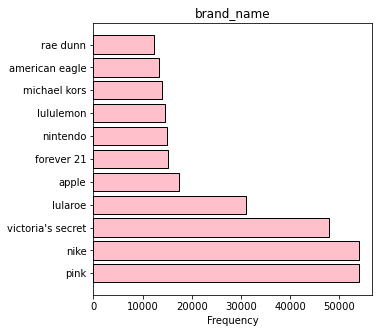

In [212]:
hlp.cat_chart(train[train['brand_name'] != 'not provided'], 'brand_name') #filtering out items without a brand name

----------------------------------------------------------------------------------------------------------------------
Top 20 Brands by Average price

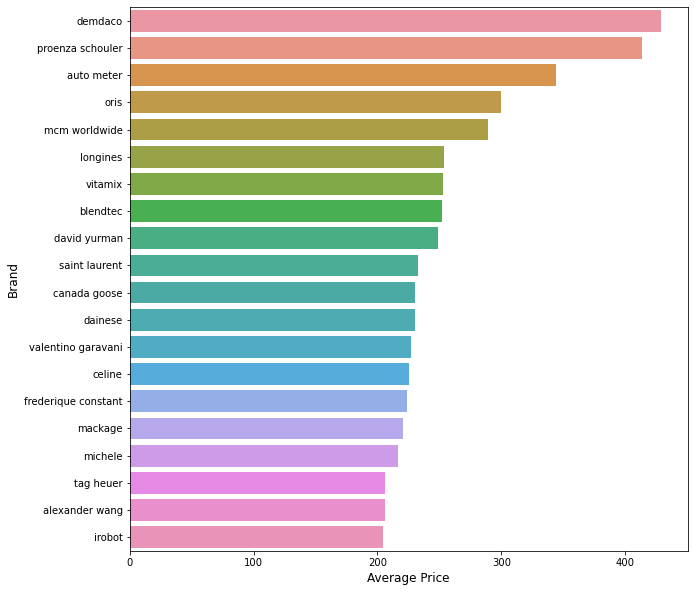

In [146]:
brand_name_items = train[train['brand_name'] != 'not provided']
brand_name_group = train.groupby('brand_name').describe()['price']
brand_name_group = brand_name_group.sort_values('mean', ascending = False)[:20]

fig, ax = plt.subplots(figsize = (10,10))
ax = sns.barplot(y = brand_name_group.reset_index()['brand_name'], x = brand_name_group.reset_index()['mean'] )
ax.set_xlabel('Average Price', size = 'large')
ax.set_ylabel('Brand', size = 'large')

plt.show()

-----------------------------------------------------------------------------------------------------------------------
The most expensive item with no brand_name provided is a diamond engagement ring

In [167]:
unbranded_items = train[train['brand_name'] == 'not provided']
unbranded_items[unbranded_items['price'] == unbranded_items.price.max()]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,maincat,subcat1,subcat2,subcat3,subcat4
1445348,1445348,vs2/i 1ct diamond engagement ring,2,women/jewelry/rings,not provided,2000.0,1,absolutely stunning diamond engagement ring pu...,7.601402,women,jewelry,rings,unknown,unknown


In [213]:
joblib.dump(train, 'train_txt_prc_start')

['train_txt_prc_start']

In [60]:
train = joblib.load('train_txt_prc_start')

## Text Preprocessing 

Machine learning algorithms typically can't process text. We need to encode our text data numerically for machine learning models to work with. We would be applying techniques such as tokenization (spliting text into bag of words) and vectorization using countvectorization, label binarizer, one hot encoding and TFIDF.

It is important that our model learns signal and not noise from text. Stopwords such as 'that', 'they', 'would've' generally represents noise and would be removed from our model. We will use the stopwords from NLKT library because the default 'english' stopword list in sklearn has some problems. For example the stopwords list does not contain 've', so after tokenizing for a word like 'would've', the 've' would be ratained in the transformed text. Also, stopswords that are transformed as a result of transformation like stemming or lemmaization might not be caught because the preprocessor step using sklearn's CountVectorizer or TfidfVectorizer is done before tokenization, but the stopwords are only removed after tokenization. Hence we create our custom preprocessor function that will first remove stop words and then stem or lemmatize what is left of the text 

We will also stem or lemmatize item_description feature and observe our models performance


In [2]:
#creating custom prerocessor to remove stopword, lemmatize or stem
def preprocess (doc, stem_lem = None, rm_stp_wrd = 'yes' ):
    
    '''fuction to stem or lemmatize a string or remove stopwords
        parameters:
            doc: string
            stem: choose either 'stem'(for stemming) or 'lemmatize'(for lemmatizing). Default is None
            rm_stp_wrd: string. variable to remove stopwords or not. Default removes stopwords'''
    
    snowball = SnowballStemmer(language = 'english')
    portstem = PorterStemmer()
    wn = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    if stem_lem == 'stem' and rm_stp_wrd == 'yes':
        doc = ' '.join([ snowball.stem(i) for i in doc.split(' ') if i not in stop_words])
    if stem_lem == 'lemmatize' and rm_stp_wrd == 'yes':
         doc = ' '.join([ wn.lemmatize(i) for i in doc.split(' ')if i not in stop_words])
    if stem_lem == 'stem' and rm_stp_wrd != 'yes':
        doc = ' '.join([ snowball.stem(i) for i in doc.split(' ')])
    if stem_lem == 'lemmatize' and rm_stp_wrd != 'yes':
         doc = ' '.join([ wn.lemmatize(i) for i in doc.split(' ')])
    if stem_lem == None and rm_stp_wrd == 'yes':
        doc = ' '.join([ i for i in doc.split(' ')if i not in stop_words])
        
    return doc

# Model Building

In [93]:
sam_train = train.sample(frac = 0.15, random_state = 42)#sample to build model and pipeline quickly because entire datasaet will run too slow
target = 'log_price'
X = sam_train.drop(['train_id', 'category_name', 'log_price', 'price'], axis =1)
y= sam_train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )

In [9]:
joblib.dump(sam_train, 'sam_train') 

['sam_train']

In [92]:
sam_train = joblib.load('sam_train')

In [17]:
#Naive base_model: Predicting mean value for price
y_mean = y_train.mean()
y_pred_baseline = [y_mean for i in range(len(y_train))]
print('RMSLE of naive base_model:', metrics.mean_squared_error( y_train, y_pred_baseline, squared = False))

RMSLE of naive base_model: 0.7455062161879851



### BASELINE MODEL - Ridge + Countvectorizer 

Our baseline model against which our final model will be measured against is a simple single-gram countvectorization (of the 'name' feature) in a ridge model with no preprocessing i.e no stopwords, removed, no stemming/lematization 

In [6]:
# cross validation function
def cross_val(model,data,feature,target):
    cval= cross_val_score(model, data[feature], target, scoring="neg_root_mean_squared_error", cv = 2, verbose = 1) 
    return cval

In [32]:

vec = CountVectorizer()
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)

cv_base = cross_val(pipe, X_train, 'name', y_train )

print("The cross validation RMSLE are: ",  str(-cv_base))
print("The mean cross validation RMSLE of base_model is" , np.mean(-cv_base) )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The cross validation RMSLE are:  [0.57158012 0.56965858 0.57079458]
The mean cross validation RMSLE of base_model is 0.5706777605096537


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.0s finished


#### Grid search to optimize hyperparameters paramaters on baseline model

In [43]:
vec = CountVectorizer()
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)

In [92]:
params = {
 'countvectorizer__ngram_range': [(1,1), (1,2)],
 'countvectorizer__preprocessor': [None,  
                                   partial(preprocess, stem_lem = 'stem', rm_stp_wrd = 'yes'), 
                                   partial(preprocess, stem_lem = 'lemmatize', rm_stp_wrd = 'yes'),
                                   partial(preprocess, stem_lem = 'lemmatize', rm_stp_wrd = 'yes'),
                                  partial(preprocess, stem_lem = 'lemmatize', rm_stp_wrd = 'no')],
 'ridge__alpha': [0.6,0.8, 1]
}

grid = GridSearchCV(estimator = pipe, param_grid = params,  scoring="neg_root_mean_squared_error", n_jobs= 1, cv=2, verbose=0 )

In [93]:
grid.fit(X_train['name'], y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(preprocessor=functools.partial(<function preprocess at 0x7f931443d430>, stem_lem='stem', rm_stp_wrd='yes'))),
                                       ('ridge', Ridge(random_state=42))]),
             n_jobs=1,
             param_grid={'countvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'countvectorizer__preprocessor': [None,
                                                           functools.partial(<function p...),
                                                           functools.partial(<function preprocess at 0x7f931443d430>, stem_lem='lemmatize', rm_stp_wrd='yes'),
                                                           functools.partial(<function preprocess at 0x7f931443d430>, stem_lem='lemmatize', rm_stp_wrd='yes'),
                                                           functools.partial(<function preprocess at 0x7f

In [96]:
res = pd.DataFrame(grid.cv_results_)
res = res.sort_values('rank_test_score')
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__ngram_range,param_countvectorizer__preprocessor,param_ridge__alpha,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
17,2.085475,0.008196,0.717119,0.015890,"(1, 2)",None,1,"{'countvectorizer__ngram_range': (1, 2), 'coun...",-0.565950,-0.562485,-0.564218,0.001732,1
29,11.899065,0.598589,12.403267,0.249066,"(1, 2)",functools.partial(<function preprocess at 0x7f...,1,"{'countvectorizer__ngram_range': (1, 2), 'coun...",-0.567615,-0.563839,-0.565727,0.001888,2
20,13.138394,0.014186,12.200445,0.035394,"(1, 2)",functools.partial(<function preprocess at 0x7f...,1,"{'countvectorizer__ngram_range': (1, 2), 'coun...",-0.568478,-0.564249,-0.566364,0.002114,3
23,11.149271,0.024227,10.363120,0.010718,"(1, 2)",functools.partial(<function preprocess at 0x7f...,1,"{'countvectorizer__ngram_range': (1, 2), 'coun...",-0.568850,-0.564243,-0.566547,0.002304,4
26,11.294258,0.171457,10.591234,0.197619,"(1, 2)",functools.partial(<function preprocess at 0x7f...,1,"{'countvectorizer__ngram_range': (1, 2), 'coun...",-0.568850,-0.564243,-0.566547,0.002304,4


In [82]:
grid.best_estimator_

Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('ridge', Ridge(random_state=42))])

In [98]:
-(grid.best_score_)

0.5642176295855554

In [100]:
#Storing estimator and scores in a dictionary. Value: estimator and score in a list 
model_dict = {}

model_dict['name_count_vec+ridg'] = [Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('ridge', Ridge(random_state=42))]), -0.5642176295855554]

In [101]:
model_dict

{'name_count_vec+ridg': [Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 2))),
                  ('ridge', Ridge(random_state=42))]),
  -0.5642176295855554]}

#### Trying Different/Multiple features with CountVetcorizer and Ridge and tuning model hyperparamaters

In [3]:
# class to process data for use in feature_union
class Processor():
    def __init__(self, feature):
        self.feature = feature
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        if x[self.feature].dtype != 'object':
            z = x[[self.feature]]
            return z
        else:
            return x[self.feature]

In [ ]:
# transformation process for each feature. All are to be concatenated using feature union before training model

pipe_name = make_pipeline(Processor('name'), CountVectorizer())
pipe_item_condition_id = make_pipeline(Processor('item_condition_id'), OneHotEncoder(dtype = int))
pipe_brand_name = make_pipeline(Processor('brand_name'), CountVectorizer())
pipe_shipping = make_pipeline( Processor('shipping'),  OneHotEncoder(dtype = int))
pipe_item_description = make_pipeline(Processor('item_description'), CountVectorizer())
pipe_maincat = make_pipeline(Processor('maincat'), CountVectorizer())
pipe_subcat1 = make_pipeline(Processor('subcat1'), CountVectorizer())
pipe_subcat2 = make_pipeline(Processor('subcat2'), CountVectorizer())
pipe_subcat3 = make_pipeline(Processor('subcat3'), CountVectorizer())
pipe_subcat4 = make_pipeline(Processor('subcat4'), CountVectorizer())

In [4]:


#function return a list of transformers for specified features. the transformers will be unpacked in a feature union 
def union(features): 
    #features should be in a list

    # a dict containing features as keys and a transformation pipeline on each feature as values
    pipe_dict = {
     'name' : pipe_name,
     'item_condition_id' : pipe_item_condition_id,
     'brand_name' : pipe_brand_name,
     'shipping' : pipe_shipping,
     'item_description' : pipe_item_description,
     'maincat' : pipe_maincat,
     'subcat1' : pipe_subcat1,
     'subcat2' : pipe_subcat2,
     'subcat3' : pipe_subcat3,
     'subcat4' : pipe_subcat4,
    }

    #putting all processing steps for each feature in a list to unpack in a feature union
    pipe_list = [pipe_dict[i] for i in features]

    return pipe_list

In [27]:
#Getting the RMSLE scores using only CV with each feature excluding shipping and item_condition which are OHC without any tuning


# cross validation function
def cross_val(model,data,feature,target):
    cval= cross_val_score(model, data[feature], target, scoring="neg_root_mean_squared_error", cv = 2, verbose = 0, n_jobs = -1) 
    return cval 

features_ls = ['name', 'item_condition_id', 'brand_name', 'shipping', 'item_description', 'maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']

resul_cv = {}
features = []
for i in features_ls:
    
    features.append(i)
    
    pipe_union = make_union(*union(features)) #unpacking transformers of each feature so that make_union class has the right input
    
    model = make_pipeline(pipe_union, Ridge(random_state = 42))
    
    score = cross_val(model, X_train, features, y_train)
    
    resul_cv[features[0]] = np.mean(-score)
    
    features = []
resul_cv

{'name': 0.5757120853254647,
 'item_condition_id': 0.7452721601382671,
 'brand_name': 0.6568268436611965,
 'shipping': 0.7256548303145474,
 'item_description': 0.6955624438302193,
 'maincat': 0.7311769571739307,
 'subcat1': 0.6954810927330599,
 'subcat2': 0.6535385650884544,
 'subcat3': 0.7444436236018405,
 'subcat4': 0.7445185048287257}

In [ ]:
#Grid search script for tuning the hyperparameter for models created with each feature. Outputs a dict of each feature as keys
# and a list of best estimator and RMSLE score as values 

#parameters to search for string features: name, brand_name etc 
params = {
 'featureunion__pipeline__countvectorizer__ngram_range': [(1,1), (1,2)],
 'featureunion__pipeline__countvectorizer__preprocessor': [None,  
                                                           partial(preprocess, stem_lem = 'stem', rm_stp_wrd = 'yes'), 
                                                           partial(preprocess, stem_lem = 'lemmatize', rm_stp_wrd = 'yes'),
                                                           partial(preprocess, stem_lem = 'lemmatize', rm_stp_wrd = 'yes'),
                                                          partial(preprocess, stem_lem = 'lemmatize', rm_stp_wrd = 'no')],
 'ridge__alpha': [0.6,0.8, 1]
}

# parameters to search for features of int type. Int type parameters(item_condition_id, shipping) are one Hot encoded
params_int = {'ridge__alpha': [0.6,0.8, 1]}

features_ls = ['name', 'item_condition_id', 
               'brand_name', 'shipping', 
               'item_description', 'maincat', 
               'subcat1', 'subcat2', 
               'subcat3', 'subcat4']

#features_ls = ['shipping']

resul = {}
features = []
for i in features_ls:
    
    features.append(i)
    
    pipe_union = make_union(*union(features))
    
    model = make_pipeline(pipe_union, Ridge(random_state = 42))
    
    if  i != 'item_condition_id' and i !='shipping':
        grid = GridSearchCV(estimator = model, param_grid = params,  
                            scoring="neg_root_mean_squared_error", 
                            n_jobs= 1, cv=2, verbose=0 )
    
    else: 
        grid = GridSearchCV(estimator = model, param_grid = params_int,  
                            scoring="neg_root_mean_squared_error", 
                            n_jobs= 1, cv=2, verbose=0 )
    
    grid.fit(X_train, y_train)
    
    resul[i] = [grid.best_estimator_, -grid.best_score_]
    
    features =[]

#resul

In [32]:
resul = joblib.load('resul')

In [392]:
#RMSLE score for each feature as the only input variable in the countvectorizer ridge model optimized with grid search
feats  = resul.keys()
scores = [resul[i][1] for i in resul]
pd.DataFrame(data = {'train_features': feats, 'grid_search_best_RMSLE_scores_for_countvectorizer+ridge': scores})

,train_features,grid_search_best_scores_for_countvectorizer+ridge
0,name,0.564218
1,item_condition_id,0.745272
2,brand_name,0.656773
3,shipping,0.725655
4,item_description,0.695566
5,maincat,0.731177
6,subcat1,0.695384
7,subcat2,0.652416
8,subcat3,0.744444
9,subcat4,0.744519


In [407]:
#'name' feature as the only train feature gave the best RMSLE score out of the all train features with the estimator below
cv_rid_name = resul['name'][0]
joblib.dump(cv_rid_name, 'cv_rid_name')
cv_rid_name

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('processor',
                                                                  <__main__.Processor object at 0x7f92ee2a6f40>),
                                                                 ('countvectorizer',
                                                                  CountVectorizer(ngram_range=(1,
                                                                                               2)))]))])),
                ('ridge', Ridge(alpha=1, random_state=42))])

In [8]:
def cross_val(model,data,feature,target):
    cval= cross_val_score(model, data[feature], target, scoring="neg_root_mean_squared_error", cv = 2, n_jobs = -1, verbose = 1) 
    return cval

#combining the best estimators for each feature from the gridsearch above and fitting it to the data(alpha =1)

features = ['name', 'item_condition_id', 'brand_name', 'shipping', 'item_description', 'maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
trans_list = [resul[i][0][0] for i in features]
pipe_union = make_union(*trans_list)
model = make_pipeline(pipe_union, Ridge(random_state = 42))
cross_val(model, X_train, features, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   32.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   32.4s finished


array([-0.53285934, -0.5329519 ])

In [410]:
features = ['name', 'item_condition_id', 'brand_name', 'shipping', 'item_description', 'maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
pipe_union = make_union(*union(features))
model = make_pipeline(pipe_union, Ridge(random_state = 42))

In [344]:
#using all features in fit a countvectorizer ridge model without default hyperparameter settings(alpha =1, no stopwords removed and no steming/lematization)

# cross validation function 
def cross_val_un(data,features,target):
    
    pipe_union = make_union(*union(features)) #conctatenating transformers
    
    model = make_pipeline(pipe_union, Ridge(random_state = 42))
    
    cval= cross_val_score(model, data[features], target, scoring="neg_root_mean_squared_error", cv = 2, n_jobs = -1, verbose = 0) 
    return cval

data = X_train
features = ['name', 'item_condition_id', 'brand_name', 'shipping', 'item_description', 'maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
target = y_train

cross_val_un(data, features, target)

array([-0.52528174, -0.52311845])

### summary: countvectorizer + ridge model

RMSLE score using only name feature(baseline model) was 0.57 and better than using any other individual feature

RMSLE score using best transformers of each individual feature(obtained from grid search) combined was 0.53

RMSLE score using using all features without any hyperparameter tuning or processing(removing stopwords, steming etc) was 0.52

The models evaluated above are all significant improvement on naive model of predicting a mean price which gave an RMSLE score of 0.75

Tuning the hyperparameters of all features in a grid would be ideal, but it took significantly long and crashed eventually 

## TFIdfVectorizer + CountVectorizer + Ridge Model

We are going to transform some of the features  using TFIdf and others using CountVectorizer and observe the model's performance

In [30]:
#Getting the RMSLE scores for ridge models built with each string feature transformed with TFIDF vectorizer
and the RMSLE scores for shipping and item_condition features which are one Hot encoded

pipe_name = make_pipeline(Processor('name'), TfidfVectorizer()) 
pipe_item_condition_id = make_pipeline(Processor('item_condition_id'), OneHotEncoder(dtype = int))
pipe_brand_name = make_pipeline(Processor('brand_name'), TfidfVectorizer())
pipe_shipping = make_pipeline( Processor('shipping'),  OneHotEncoder(dtype = int))
pipe_item_description = make_pipeline(Processor('item_description'), TfidfVectorizer()) 
pipe_maincat = make_pipeline(Processor('maincat'), TfidfVectorizer())
pipe_subcat1 = make_pipeline(Processor('subcat1'), TfidfVectorizer())
pipe_subcat2 = make_pipeline(Processor('subcat2'), TfidfVectorizer())
pipe_subcat3 = make_pipeline(Processor('subcat3'), TfidfVectorizer())
pipe_subcat4 = make_pipeline(Processor('subcat4'), TfidfVectorizer())


# cross validation function
def cross_val(model,data,feature,target):
    cval= cross_val_score(model, data[feature], target, scoring="neg_root_mean_squared_error", cv = 2, verbose = 0, n_jobs = -1) 
    return cval 

features_ls = ['name', 'item_condition_id', 'brand_name', 'shipping', 'item_description', 'maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']

resul_tfidf = {}
features = []
for i in features_ls:
    
    features.append(i)
    
    pipe_union = make_union(*union(features))
    
    model = make_pipeline(pipe_union, Ridge(random_state = 42))
    
    score = cross_val(model, X_train, features, y_train)
    
    resul_tfidf[features[0]] = np.mean(-score)
    
    features = []
resul_tfidf


{'name': 0.5704584570034648,
 'item_condition_id': 0.7452721601382671,
 'brand_name': 0.6568457189701782,
 'shipping': 0.7256548303145474,
 'item_description': 0.6199858190135039,
 'maincat': 0.7311764758873979,
 'subcat1': 0.6954028799216354,
 'subcat2': 0.6535120435037785,
 'subcat3': 0.744443584560879,
 'subcat4': 0.7445183135344338}

In [35]:
resul_tfidf

{'name': 0.5704584570034648,
 'item_condition_id': 0.7452721601382671,
 'brand_name': 0.6568457189701782,
 'shipping': 0.7256548303145474,
 'item_description': 0.6199858190135039,
 'maincat': 0.7311764758873979,
 'subcat1': 0.6954028799216354,
 'subcat2': 0.6535120435037785,
 'subcat3': 0.744443584560879,
 'subcat4': 0.7445183135344338}

In [37]:
resul_tfidf.values()

dict_values([0.5704584570034648, 0.7452721601382671, 0.6568457189701782, 0.7256548303145474, 0.6199858190135039, 0.7311764758873979, 0.6954028799216354, 0.6535120435037785, 0.744443584560879, 0.7445183135344338])

In [39]:
#RMSLE score for each feature as the only input variable in the countvectorizer ridge model optimized with grid search
feats  = resul.keys()
scores_cv = [resul[i][1] for i in resul]
scores_tfidf = resul_tfidf.values()
pd.DataFrame(data = {'train_features': feats,
                     'RMSLE_scores_for_countvectorizer+ridge': scores_cv,
                      'RMSLE_scores_for_tfidfvectorizer+ridge': scores_tfidf})
#note that for the result below the integer features(shipping and item_description) are OHC hence the results are the same

,train_features,RMSLE_scores_for_countvectorizer+ridge,RMSLE_scores_for_tfidfvectorizer+ridge
0,name,0.564218,0.570458
1,item_condition_id,0.745272,0.745272
2,brand_name,0.656773,0.656846
3,shipping,0.725655,0.725655
4,item_description,0.695566,0.619986
5,maincat,0.731177,0.731176
6,subcat1,0.695384,0.695403
7,subcat2,0.652416,0.653512
8,subcat3,0.744444,0.744444
9,subcat4,0.744519,0.744518


In [44]:
def cross_val(model,data,feature,target):
    cval= cross_val_score(model, data[feature], target, scoring="neg_root_mean_squared_error", cv = 2, verbose = 1, n_jobs = -1) 
    return cval


tfif = TfidfVectorizer(ngram_range=(1,2))
ridg = Ridge(random_state=42)
pipe = make_pipeline(tfif, ridg)

cv_base = cross_val(pipe, X_train, 'name', y_train )

print("The cross validation RMSLE are: ",  str(-cv_base))
print("The mean cross validation RMSLE of base_model is" , np.mean(-cv_base) )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


The cross validation RMSLE are:  [0.560544   0.55634105]
The mean cross validation RMSLE of base_model is 0.5584425236997853


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s finished


In [ ]:
#significant improvement on item_description using tfidf compared with countvectorizer. 
#For the other features tfidf and countvec results are similar 

In [18]:
#RMSLE score using tfidf on item_description and countvec on all other string features


# transformation process for each feature. All are to be concatenated using feature union before training model
pipe_name = make_pipeline(Processor('name'), CountVectorizer())
pipe_item_condition_id = make_pipeline(Processor('item_condition_id'), OneHotEncoder(dtype = int))
pipe_brand_name = make_pipeline(Processor('brand_name'), CountVectorizer())
pipe_shipping = make_pipeline( Processor('shipping'),  OneHotEncoder(dtype = int))
pipe_item_description = make_pipeline(Processor('item_description'), TfidfVectorizer()) #Tfidf transformation on item_description
pipe_maincat = make_pipeline(Processor('maincat'), CountVectorizer())
pipe_subcat1 = make_pipeline(Processor('subcat1'), CountVectorizer())
pipe_subcat2 = make_pipeline(Processor('subcat2'), CountVectorizer())
pipe_subcat3 = make_pipeline(Processor('subcat3'), CountVectorizer())
pipe_subcat4 = make_pipeline(Processor('subcat4'), CountVectorizer())

def cross_val_un(data,features,target):
    
    pipe_union = make_union(*union(features)) #conctatenating transformers
    
    model = make_pipeline(pipe_union, Ridge(random_state = 42))
    
    cval= cross_val_score(model, data[features], target, scoring="neg_root_mean_squared_error", cv = 2, n_jobs = -1, verbose = 0) 
    return cval

data = X_train
features = ['name', 'item_condition_id', 'brand_name', 'shipping', 'item_description', 'maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
target = y_train

cross_val_un(data, features, target)

array([-0.51007293, -0.50820363])

In [ ]:
#RMSLE score of the above is slightly better that the result of using countvec on all string features including item_description

In [40]:
#Grid search script for tuning the hyperparameter for  a Ridge model built with the item_description feature and transformed using 
#TFIDF vectorizer

pipe_item_description = make_pipeline(Processor('item_description'), TfidfVectorizer()) 


#parameters to search for string features: name, brand_name etc 
params = {
 'featureunion__pipeline__tfidfvectorizer__ngram_range': [(1,1), (1,2)],
  'featureunion__pipeline__tfidfvectorizer__max_df': [0.8, 1.0],
    'featureunion__pipeline__tfidfvectorizer__min_df': [3, 1],
 'featureunion__pipeline__tfidfvectorizer__preprocessor': [None,  
                                                           partial(preprocess, stem_lem = 'stem', rm_stp_wrd = 'yes'), 
                                                           partial(preprocess, stem_lem = 'lemmatize', rm_stp_wrd = 'yes'),
                                                           partial(preprocess, stem_lem = 'lemmatize', rm_stp_wrd = 'yes'),
                                                          partial(preprocess, stem_lem = 'lemmatize', rm_stp_wrd = 'no')],
 'ridge__alpha': [0.6,0.8, 1]
}

# parameters to search for features of int type. Int type parameters(item_condition_id, shipping) are one Hot encoded
params_int = {'ridge__alpha': [0.6,0.8, 1]}

features_ls = ['item_description']


resul_2 = {}
features = []
for i in features_ls:
    
    features.append(i)
    
    pipe_union = make_union(*union(features))
    
    model = make_pipeline(pipe_union, Ridge(random_state = 42))
    
    if  i != 'item_condition_id' and i !='shipping':
        grid = GridSearchCV(estimator = model, param_grid = params,  
                            scoring="neg_root_mean_squared_error", 
                            n_jobs= 1, cv=2, verbose=0 )
    
    else: 
        grid = GridSearchCV(estimator = model, param_grid = params_int,  
                            scoring="neg_root_mean_squared_error", 
                            n_jobs= 1, cv=2, verbose=0 )
    
    grid.fit(X_train, y_train)
    
    resul_2[i] = [grid.best_estimator_, -grid.best_score_]
    
    features =[]

resul_2

{'item_description': [Pipeline(steps=[('featureunion',
                   FeatureUnion(transformer_list=[('pipeline',
                                                   Pipeline(steps=[('processor',
                                                                    <__main__.Processor object at 0x7f059b91da90>),
                                                                   ('tfidfvectorizer',
                                                                    TfidfVectorizer(max_df=0.8,
                                                                                    ngram_range=(1,
                                                                                                 2)))]))])),
                  ('ridge', Ridge(alpha=1, random_state=42))]),
  0.6051034378696895]}

In [41]:
grid.best_params_

{'featureunion__pipeline__tfidfvectorizer__max_df': 0.8,
 'featureunion__pipeline__tfidfvectorizer__min_df': 1,
 'featureunion__pipeline__tfidfvectorizer__ngram_range': (1, 2),
 'featureunion__pipeline__tfidfvectorizer__preprocessor': None,
 'ridge__alpha': 1}

In [46]:
#RMSLE score using the best params on the name countvec+ ridge model and the the item_description tfidf+ridge model
# transformation process for each feature. All are to be concatenated using feature union before training model
pipe_name = make_pipeline(Processor('name'), TfidfVectorizer(ngram_range = (1,2)))
pipe_item_condition_id = make_pipeline(Processor('item_condition_id'), OneHotEncoder(dtype = int))
pipe_brand_name = make_pipeline(Processor('brand_name'), CountVectorizer())
pipe_shipping = make_pipeline( Processor('shipping'),  OneHotEncoder(dtype = int))
pipe_item_description = make_pipeline(Processor('item_description'), TfidfVectorizer(ngram_range = (1,2), max_df = 0.8)) 
pipe_maincat = make_pipeline(Processor('maincat'), CountVectorizer())
pipe_subcat1 = make_pipeline(Processor('subcat1'), CountVectorizer())
pipe_subcat2 = make_pipeline(Processor('subcat2'), CountVectorizer())
pipe_subcat3 = make_pipeline(Processor('subcat3'), CountVectorizer())
pipe_subcat4 = make_pipeline(Processor('subcat4'), CountVectorizer())

def cross_val_un(data,features,target):
    
    pipe_union = make_union(*union(features)) #conctatenating transformers
    
    model = make_pipeline(pipe_union, Ridge(random_state = 42))
    
    cval= cross_val_score(model, data[features], target, scoring="neg_root_mean_squared_error", cv = 2, n_jobs = -1, verbose = 0) 
    return cval

data = X_train
features = ['name', 'item_condition_id', 'brand_name', 'shipping', 'item_description', 'maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
target = y_train

scr = cross_val_un(data, features, target)
print (scr)
np.mean(-scr)

[-0.49163658 -0.48981972]


0.4907281512835065

In [21]:
#checking the result of the final ridge model on a much larger sample size

sam_train = copy.copy(train)
target = 'log_price'
X = sam_train.drop(['train_id', 'category_name', 'log_price', 'price'], axis =1)
y= sam_train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )

#------
#RMSLE score using the best params on the name countvec+ ridge model and the the item_description tfidf+ridge model

# transformation process for each feature. All are to be concatenated using feature union before training model
pipe_name = make_pipeline(Processor('name'), TfidfVectorizer(ngram_range = (1,2)))
pipe_item_condition_id = make_pipeline(Processor('item_condition_id'), OneHotEncoder(dtype = int))
pipe_brand_name = make_pipeline(Processor('brand_name'), CountVectorizer())
pipe_shipping = make_pipeline( Processor('shipping'),  OneHotEncoder(dtype = int))
pipe_item_description = make_pipeline(Processor('item_description'), TfidfVectorizer(ngram_range = (1,2), max_df = 0.8)) 
pipe_maincat = make_pipeline(Processor('maincat'), CountVectorizer())
pipe_subcat1 = make_pipeline(Processor('subcat1'), CountVectorizer())
pipe_subcat2 = make_pipeline(Processor('subcat2'), CountVectorizer())
pipe_subcat3 = make_pipeline(Processor('subcat3'), CountVectorizer())
pipe_subcat4 = make_pipeline(Processor('subcat4'), CountVectorizer())

def cross_val_un(data,features,target):
    
    pipe_union = make_union(*union(features)) #conctatenating transformers
    
    model = make_pipeline(pipe_union, Ridge(random_state = 42))
    
    cval= cross_val_score(model, data[features], target, scoring="neg_root_mean_squared_error", cv = 2, n_jobs = -1, verbose = 0) 
    return cval

data = X_train
features = ['name', 'item_condition_id', 'brand_name', 'shipping', 'item_description', 'maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
target = y_train

scr = cross_val_un(data, features, target)
print (scr)
np.mean(-scr)

[-0.45071525 -0.45149757]


0.45110640862971196

### summary: countvectorizer +Tfidfvectorizer + ridge model

Comparing RMSLE scores of the ridge models built using countvectorizer and tfidfvector of each feature, there was only significant difference with the item_description feature. Hence the tfidf feature was further explored in a grid search for further optimization

The final model using a tfidf transfomation of the item_description feature and countvectorization on all other string features with the best params of each obtain from the grid search analysis resulted in an RMSLE of 0.49 which is better than the ridge model built using only countvectorizer transformation

Using the final model hyperparameters with a larger sample size improved the RMSLE score to 0.45


In [82]:
#RMSLE score using the best params on the name countvec+ ridge model and the the item_description tfidf+ridge model

# transformation process for each feature. All are to be concatenated using feature union before training model
pipe_name = make_pipeline(Processor('name'), TfidfVectorizer(ngram_range = (1,2)))
pipe_item_condition_id = make_pipeline(Processor('item_condition_id'), OneHotEncoder(dtype = int))
pipe_brand_name = make_pipeline(Processor('brand_name'), CountVectorizer())
pipe_shipping = make_pipeline( Processor('shipping'),  OneHotEncoder(dtype = int))
pipe_item_description = make_pipeline(Processor('item_description'), TfidfVectorizer(ngram_range = (1,2), max_df = 0.8)) 
pipe_maincat = make_pipeline(Processor('maincat'), CountVectorizer())
pipe_subcat1 = make_pipeline(Processor('subcat1'), CountVectorizer())
pipe_subcat2 = make_pipeline(Processor('subcat2'), CountVectorizer())
pipe_subcat3 = make_pipeline(Processor('subcat3'), CountVectorizer())
pipe_subcat4 = make_pipeline(Processor('subcat4'), CountVectorizer())
 
pipe_union = make_union(*union(features)) #conctatenating transformers
    
model = make_pipeline(pipe_union, Ridge(random_state = 42))
    
data = X_train
features = ['name', 'item_condition_id', 'brand_name', 'shipping', 'item_description', 'maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
target = y_train


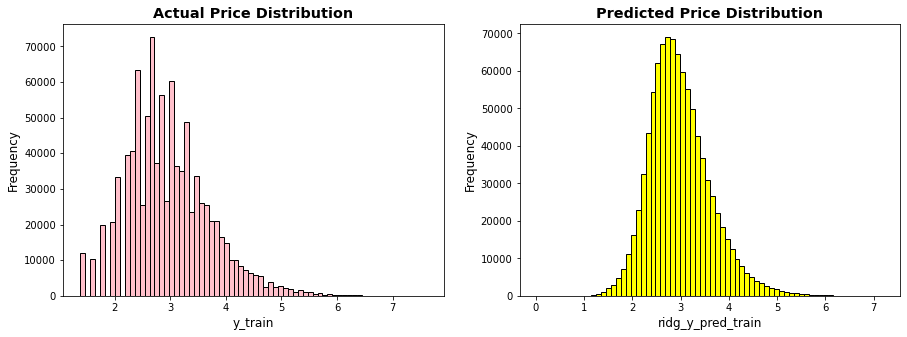

In [83]:
#compare actual log_price distribution to predicted using larger train sample size (80% of total)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train) 

fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(y_train, bins = 70,  linewidth=1, edgecolor="black", facecolor = 'pink')
ax[0].set_xlabel('y_train', fontsize = 'large')
ax[0].set_ylabel('Frequency', fontsize = 'large')
ax[0].set_title('Actual Price Distribution', fontsize = 'x-large', fontweight = 'bold')

ax[1].hist(y_train_pred, bins = 70,  linewidth=1, edgecolor="black", facecolor = 'yellow')
ax[1].set_xlabel('ridg_y_pred_train', fontsize = 'large')
ax[1].set_ylabel('Frequency', fontsize = 'large')
ax[1].set_title('Predicted Price Distribution', fontsize = 'x-large', fontweight = 'bold')

plt.show()

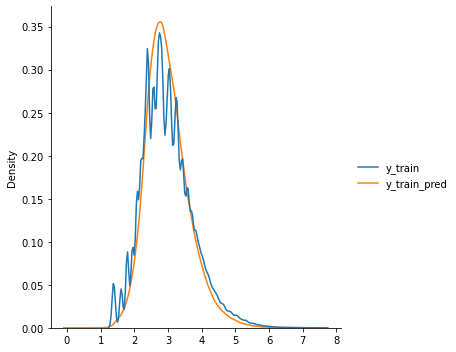

In [89]:
#Plotting distribution of actual train  and predicted train
z_train = pd.DataFrame(({'y_train':y_train, 'y_train_pred': y_train_pred})) 
ax1 = sns.displot(z_train, kind="kde")

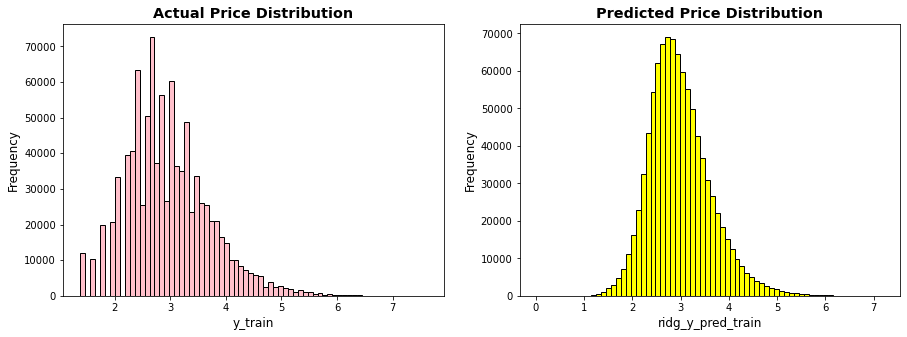

In [90]:
#compare actual log_price distribution to predicted on test sample

y_test_pred = model.predict(X_test) 

fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(y_train, bins = 70,  linewidth=1, edgecolor="black", facecolor = 'pink')
ax[0].set_xlabel('y_train', fontsize = 'large')
ax[0].set_ylabel('Frequency', fontsize = 'large')
ax[0].set_title('Actual Price Distribution', fontsize = 'x-large', fontweight = 'bold')

ax[1].hist(y_train_pred, bins = 70,  linewidth=1, edgecolor="black", facecolor = 'yellow')
ax[1].set_xlabel('ridg_y_pred_train', fontsize = 'large')
ax[1].set_ylabel('Frequency', fontsize = 'large')
ax[1].set_title('Predicted Price Distribution', fontsize = 'x-large', fontweight = 'bold')

plt.show()

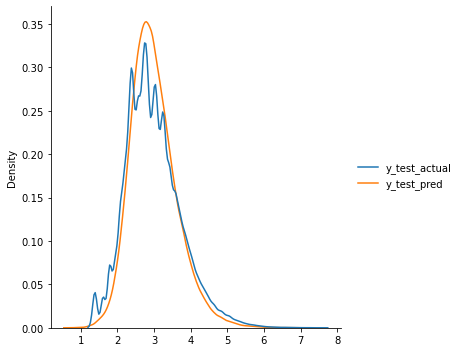

In [91]:
#Plotting distribution of actual test  and predicted test
z_test = pd.DataFrame(({'y_test_actual':y_test, 'y_test_pred': y_test_pred})) 
sns.displot(z_test, kind="kde")

## LGB Model

In [5]:
import time

In [6]:
train = joblib.load('train_txt_prc_start')

In [7]:
sam_train = copy.copy(train)
target = 'log_price'
X = sam_train.drop(['train_id', 'category_name', 'log_price', 'price'], axis =1)
y= sam_train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.85, random_state = 42 )

In [10]:
#RMSLE score using the Lgbm
# transformation process for each feature. All are to be concatenated using feature union before training model
pipe_name = make_pipeline(Processor('name'), TfidfVectorizer(ngram_range = (1,2)))
pipe_item_condition_id = make_pipeline(Processor('item_condition_id'), OneHotEncoder(dtype = int))
pipe_brand_name = make_pipeline(Processor('brand_name'), CountVectorizer())
pipe_shipping = make_pipeline( Processor('shipping'),  OneHotEncoder(dtype = int))
pipe_item_description = make_pipeline(Processor('item_description'), TfidfVectorizer(ngram_range = (1,2), max_df = 0.8)) 
pipe_maincat = make_pipeline(Processor('maincat'), CountVectorizer())
pipe_subcat1 = make_pipeline(Processor('subcat1'), CountVectorizer())
pipe_subcat2 = make_pipeline(Processor('subcat2'), CountVectorizer())
pipe_subcat3 = make_pipeline(Processor('subcat3'), CountVectorizer())
pipe_subcat4 = make_pipeline(Processor('subcat4'), CountVectorizer())

def cross_val_un(data,features,target):
    
    pipe_union = make_union(*union(features)) #conctatenating transformers
    
    #the hyperparameters were chosed afer individual tuning. Grid search took significantly long and often ended in a computer crash
    model = make_pipeline(pipe_union, lgb.LGBMRegressor(boosting_type ='gbdt', num_leaves= 30,
                                                         n_estimators= 1000,
                                                         min_child_samples= 5,
                                                         max_depth =15, subsample = 0.5, colsample_bytree = 0.5,
                                                         learning_rate = 0.2, random_state = 95, n_jobs = -1, verbose = 0, force_col_wise= True))
    
    

    cval= cross_val_score(model, data[features], target, scoring="neg_root_mean_squared_error", cv = 2, n_jobs = 1, verbose = 1) 
    return cval

data = X_train
features = ['name', 'item_condition_id', 'brand_name', 'shipping', 'item_description', 'maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
target = y_train

start = time.time()
scr = cross_val_un(data, features, target)
print (scr)
print('score--->' , np.mean(-scr))

print('run_time----->' ,time.time() - start)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[-0.45904397 -0.46042006]
score---> 0.45973201944872166
run_time-----> 32291.96058511734


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 538.2min finished


In [8]:
#Building lgbm_model 

# transformation process for each feature. All are to be concatenated using feature union before training model
pipe_name = make_pipeline(Processor('name'), TfidfVectorizer(ngram_range = (1,2)))
pipe_item_condition_id = make_pipeline(Processor('item_condition_id'), OneHotEncoder(dtype = int))
pipe_brand_name = make_pipeline(Processor('brand_name'), CountVectorizer())
pipe_shipping = make_pipeline( Processor('shipping'),  OneHotEncoder(dtype = int))
pipe_item_description = make_pipeline(Processor('item_description'), TfidfVectorizer(ngram_range = (1,2), max_df = 0.8)) 
pipe_maincat = make_pipeline(Processor('maincat'), CountVectorizer())
pipe_subcat1 = make_pipeline(Processor('subcat1'), CountVectorizer())
pipe_subcat2 = make_pipeline(Processor('subcat2'), CountVectorizer())
pipe_subcat3 = make_pipeline(Processor('subcat3'), CountVectorizer())
pipe_subcat4 = make_pipeline(Processor('subcat4'), CountVectorizer())
 


features = ['name', 'item_condition_id', 'brand_name', 'shipping', 'item_description', 'maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']


pipe_union = make_union(*union(features)) #conctatenating transformers
    
lgb_model = make_pipeline(pipe_union, lgb.LGBMRegressor(boosting_type ='gbdt', num_leaves= 30,
                                                         n_estimators= 1000,
                                                         min_child_samples= 5,
                                                         max_depth =15, subsample = 0.5, colsample_bytree = 0.5,
                                                         learning_rate = 0.2, random_state = 95, n_jobs = -1, verbose = 0, force_col_wise= True))
    



In [9]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('processor',
                                                                  <__main__.Processor object at 0x7faf2ea17bb0>),
                                                                 ('tfidfvectorizer',
                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                               2)))])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('processor',
                                                                  <__main__.Processor object at 0x7faf2ea17b50>),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(dtype

In [ ]:
  model = make_pipeline(pipe_union, lgb.LGBMRegressor(boosting_type ='gbdt', num_leaves= 30,
                                                         n_estimators= 500,
                                                         min_child_samples= 5,
                                                         max_depth =15, subsample = 0.5, colsample_bytree = 0.5,
                                                         learning_rate = 0.2, random_state = 95, n_jobs = -1, verbose = 1))
    0.49

In [ ]:
model = make_pipeline(pipe_union, lgb.LGBMRegressor(random_state = 42, learning_rate=0.2, n_estimators = 500,
                                                        max_depth=15, min_child_samples=7, num_leaves=20, verbose= 1))

0.49

In [61]:
 # A gridsearch with several hyperparameters  took days to run, so a simpler individual parameter tuning was done

# tuning boosting hyperparameter n_estimators with Gridsearch
lgb_model = lgb.LGBMRegressor(num_leaves= 30, max_depth =15, subsample = 0.1, random_state = 95, max_features = 'sqrt')
param_grid = {'n_estimators': range(500, 1001, 100)}
lgb_grid = GridSearchCV(lgb_model, param_grid, cv=3,  scoring = "neg_root_mean_squared_error", verbose =2, pre_dispatch= 1, return_train_score = True)

lgb_grid.fit(x_train, y_train)

#best_estimator = lgb_grid.best_params_
#best_estimator

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Unknown parameter: max_features
[CV] ................................. n_estimators=500, total=24.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.0min remaining:    0.0s


[CV] n_estimators=500 ................................................
[LightGBM] [Warning] Unknown parameter: max_features
[CV] ................................. n_estimators=500, total=26.4min
[CV] n_estimators=500 ................................................
[LightGBM] [Warning] Unknown parameter: max_features
[CV] ................................. n_estimators=500, total=20.2min
[CV] n_estimators=600 ................................................
[LightGBM] [Warning] Unknown parameter: max_features
[CV] ................................. n_estimators=600, total=29.2min
[CV] n_estimators=600 ................................................
[LightGBM] [Warning] Unknown parameter: max_features
[CV] ................................. n_estimators=600, total=29.5min
[CV] n_estimators=600 ................................................
[LightGBM] [Warning] Unknown parameter: max_features
[CV] ................................. n_estimators=600, total=30.8min
[CV] n_estimators=700 ...

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 744.2min finished


[LightGBM] [Warning] Unknown parameter: max_features


GridSearchCV(cv=3,
             estimator=LGBMRegressor(max_depth=15, max_features='sqrt',
                                     num_leaves=30, random_state=95,
                                     subsample=0.1),
             param_grid={'n_estimators': range(500, 1001, 100)}, pre_dispatch=1,
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [10]:
# n_estimator = 1000 had the best score. Possibly higher number of estimators will produce slightly better score but a much greater computational effort
pd.DataFrame(lgb_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1394.243951,151.244330,22.594402,1.271093,500,{'n_estimators': 500},-0.486714,-0.485905,-0.487266,-0.486628,0.000559,6,-0.478863,-0.479761,-0.479141,-0.479255,0.000375
1,1754.175224,38.338580,35.109096,3.506277,600,{'n_estimators': 600},-0.481463,-0.480579,-0.481988,-0.481343,0.000582,5,-0.472291,-0.473134,-0.472604,-0.472676,0.000348
2,6685.051727,6637.183511,35.021154,5.256370,700,{'n_estimators': 700},-0.477261,-0.476269,-0.477651,-0.477060,0.000582,4,-0.466811,-0.467602,-0.466975,-0.467129,0.000341
3,1441.041262,81.841506,35.391406,2.669046,800,{'n_estimators': 800},-0.473795,-0.472655,-0.474003,-0.473484,0.000593,3,-0.462064,-0.462791,-0.462086,-0.462313,0.000338
4,1466.056329,12.325125,40.866542,0.943646,900,{'n_estimators': 900},-0.470771,-0.469499,-0.470867,-0.470379,0.000623,2,-0.457803,-0.458459,-0.457773,-0.458012,0.000316
5,1498.259088,85.602098,44.384556,3.884511,1000,{'n_estimators': 1000},-0.468082,-0.466945,-0.468297,-0.467775,0.000593,1,-0.453973,-0.454705,-0.454013,-0.454230,0.000336


In [8]:
%%time
##tuning boosting hyperparameter max_depth in a Gridsearch with n_estimaor = 1000
lgb_model = lgb.LGBMRegressor(num_leaves= 30, learning_rate = 0.1,  n_estimator = 1000, subsample = 0.1, random_state = 95)
param_grid = {'max_depth ': range(10, 41, 10)}
lgb_grid = GridSearchCV(lgb_model, param_grid, cv=3,  scoring = "neg_root_mean_squared_error", verbose =2, pre_dispatch= 1, return_train_score = True)

lgb_grid.fit(x_train, y_train)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.999887
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.999854
[LightGBM] [Debug] init for col-wise cost 3049.007474 seconds, init for row-wise cost 2671.026316 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2672.258011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1504477
[LightGBM] [Info] Number of data points in the train set: 1481661, number of used features: 357674
[LightGBM] [Info] Start training from score 2.980816
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 20 a

LGBMRegressor(learning_rate=0.5, max_depth=15, min_child_samples=7,
              num_leaves=20, random_state=95, verbose=2)

In [95]:
# Because it took significantly long time to do a gridsearch cross validation to simultaneously tune multiple hyperperameters,
# individual parameters were tuned and RMSLE were computed(see cells below) to determine  the best values which resulted in the model below 

lgb_model = lgb.LGBMRegressor(num_leaves= 30,
 n_estimators= 1000,
 min_child_samples= 5,
 max_depth =15, subsample = 0.5, colsample_bytree = 0.5,
 learning_rate = 0.2, random_state = 95, n_jobs = -1, verbose = 2)


lgb_model.fit(x_train,y_train)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.999889
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.999851
[LightGBM] [Debug] init for col-wise cost 2514.257345 seconds, init for row-wise cost 2631.477864 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2684.377804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1504294
[LightGBM] [Info] Number of data points in the train set: 1185328, number of used features: 358390
[LightGBM] [Info] Start training from score 2.980522
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 30

LGBMRegressor(colsample_bytree=0.5, learning_rate=0.2, max_depth=15,
              min_child_samples=5, n_estimators=1000, num_leaves=30,
              random_state=95, subsample=0.5, verbose=2)

In [94]:
joblib.dump(lgb_model, 'lgb_model_1')

['lgb_model_1']

In [5]:
lgb_model = joblib.load('lgb_model')

In [6]:
lgb_model

LGBMRegressor(learning_rate=0.3, max_depth=15, min_child_samples=5,
              n_estimators=800, num_leaves=30, random_state=95, subsample=0.5,
              verbose=2)

In [12]:
lgb_model_1

LGBMRegressor(colsample_bytree=0.5, learning_rate=0.3, max_depth=15,
              min_child_samples=5, n_estimators=1000, num_leaves=30,
              random_state=95, subsample=0.5, verbose=2)

In [97]:
#model's prediction for train and test samples
lgb_y_pred_train = lgb_model.predict(x_train)
lgb_y_pred_test = lgb_model.predict(x_test)

In [92]:
#best result from tuning hyperparameters

print('train_RMSLE_lgb---> ', metrics.mean_squared_error(y_train, lgb_y_pred_train, squared = False) )
print('test_RMSLE_lgb---> ', metrics.mean_squared_error(y_test, lgb_y_pred_test, squared = False) )

train_RMSLE_lgb--->  0.4193230589832726
test_RMSLE_lgb--->  0.4455094296811345


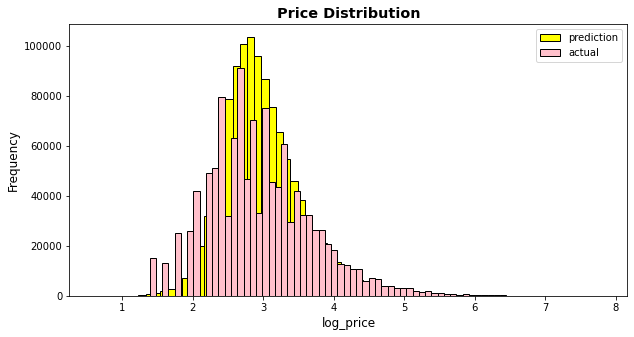

In [26]:
fig,ax = plt.subplots(1,1, figsize=(10,5))

ax.hist(lgb_y_pred_train, bins = 70,  linewidth=1, edgecolor="black", facecolor = 'yellow', label = 'prediction')
ax.legend()

ax.hist(y_train, bins = 70,  linewidth=1, edgecolor="black", facecolor = 'pink', label = 'actual')
ax.legend()

ax.set_xlabel('log_price', fontsize = 'large')
ax.set_ylabel('Frequency', fontsize = 'large')
ax.set_title('Price Distribution', fontsize = 'x-large', fontweight = 'bold')


plt.show()

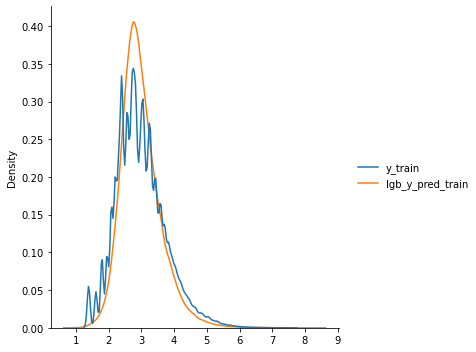

In [52]:
#Plotting distribution of actual train  and predicted train
z_train = pd.DataFrame(({'y_train':y_train, 'lgb_y_pred_train': lgb_y_pred_train})) 
ax1 = sns.displot(z_train, kind="kde")

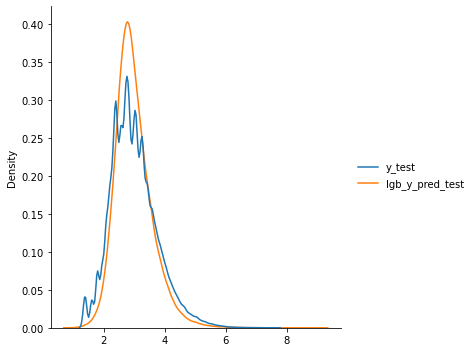

In [53]:
#Plotting distribution of actual train  and predicted train
z_train = pd.DataFrame(({'y_test':y_test, 'lgb_y_pred_test': lgb_y_pred_test})) 
ax1 = sns.displot(z_train, kind="kde")

## ENSEMBLE

##### Combining the predictions of both the ridge and lgb models produced better RMSLE score

In [28]:
y_pred_train =(lgb_y_pred_train + ridg_y_pred_train)/2
y_pred_test =(lgb_y_pred_test + ridg_y_pred_test)/2

In [29]:

print('train_RMSLE_ensemble---> ', metrics.mean_squared_error(y_train, y_pred_train, squared = False) )
print('test_RMSLE_ensemble---> ', metrics.mean_squared_error(y_test, y_pred_test, squared = False) )

train_RMSLE_ensemble--->  0.3702755292815347
test_RMSLE_ensemble--->  0.431755881580021


In [46]:
#dataframe of actual and predicted price in dollars for train set 
log_train = pd.DataFrame(({'y_train':y_train, 'lgb_y_pred_train': lgb_y_pred_train})) #dataframe of log transformed price 
dollar_train = z.apply(lambda x: np.expm1(x)) #inverse transform to show actual dollar value _(expm1 is inverse of log1p)
dollar_train

,y_train,lgb_y_pred_train
313913,18.0,28.791528
1424026,10.0,12.521851
1058847,65.0,24.738312
387290,28.0,35.129319
16896,7.0,9.678971
...,...,...
836948,19.0,20.667769
491517,64.0,35.574487
471165,3.0,4.294617
492011,6.0,5.527066


In [ ]:
#dataframe of actual and predicted price in dollars for test set
log_test = pd.DataFrame(({'y_train':y_test, 'lgb_y_pred_test': lgb_y_pred_test})) #dataframe of log transformed price 
dollar_test = z.apply(lambda x: np.expm1(x)) #inverse transform to show actual dollar value _(expm1 is inverse of log1p)
dollar_test

## FUTURE WORk


#### Create flask app of model and deploy to the cloud using Azure